# Data Processing Pipeline
**Goal**: Clean and prepare TSLA, BND, and SPY data for modeling.  
**Steps**:  
1. Load raw data  
2. Validate data types and handle missing values  
3. Calculate derived metrics (returns, volatility)  
4. Save processed data to `data/processed/`

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os 
import sys

sys.path.append(os.path.abspath("../"))
from src.utils.data_processing_utils import load_ticker_data, preprocess_data, calculate_metrics

DATA_RAW_DIR = Path("../data/raw")
DATA_PROCESSED_DIR = Path("../data/processed")
DATA_PROCESSED_DIR.mkdir(exist_ok=True)

## 1. Load Raw Data
- Confirm data types (e.g., `Date` as datetime, numeric cols as float)  
- Check for missing values  

In [4]:
# Load all tickers
tickers = ["TSLA", "BND", "SPY"]
data = {ticker: load_ticker_data(ticker, DATA_RAW_DIR) for ticker in tickers}

# Example: Display data summary
print("Tesla data info:")
data["TSLA"].info()

print("\nBND data info:")
data["BND"].info()

print("\nSPY data info:")
data["SPY"].info()

Tesla data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2535 non-null   float64
 1   High       2535 non-null   float64
 2   Low        2535 non-null   float64
 3   Close      2535 non-null   float64
 4   Adj Close  2535 non-null   float64
 5   Volume     2535 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 138.6 KB

BND data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2535 non-null   float64
 1   High       2535 non-null   float64
 2   Low        2535 non-null   float64
 3   Close      2535 non-null   float64
 4   Adj Close  2535 non-null   float64
 5   Volume     2535 non-null   int64  
dtypes: float64(5), int64(1

In [5]:
# data shapes
for ticker in tickers:
    print(f"\n{ticker} shape:")
    print(data[ticker].shape)


TSLA shape:
(2535, 6)

BND shape:
(2535, 6)

SPY shape:
(2535, 6)


## 2. Handle Missing Values
- **Prices**: Forward-fill (markets closed on weekends/holidays)  
- **Volume**: Set to 0 on non-trading days  
- Confirm no nulls remain  

In [6]:
# Apply to all tickers
processed_data = {ticker: preprocess_data(df) for ticker, df in data.items()}

# Check TSLA for nulls
assert processed_data["TSLA"].isnull().sum().sum() == 0, "Null values remain!"
print("Data preprocessed successfully!")

Data preprocessed successfully!


In [7]:
# new data shape
for ticker in tickers:
    print(f"\n{ticker} shape:")
    print(processed_data[ticker].shape)


TSLA shape:
(2631, 6)

BND shape:
(2631, 6)

SPY shape:
(2631, 6)


## 3. Calculate Derived Metrics
- **Daily Returns**: `(Adj Close_t / Adj Close_{t-1}) - 1`  
- **Rolling Volatility**: 21-day std of returns  

In [8]:
# Apply to all tickers
final_data = {ticker: calculate_metrics(df) for ticker, df in processed_data.items()}

# Example: View TSLA metrics
final_data["TSLA"][["Adj Close", "Daily Return", "21D Volatility", "Log Return"]].tail()

,Adj Close,Daily Return,21D Volatility,Log Return
Date,,,,
2025-07-24,305.299988,-0.081970,0.033476,-0.085525
2025-07-25,316.059998,0.035244,0.034478,0.034637
2025-07-28,325.589996,0.030152,0.035100,0.029707
2025-07-29,321.200012,-0.013483,0.034979,-0.013575
2025-07-30,319.040009,-0.006725,0.032757,-0.006748


In [9]:
# Save to processed/
for ticker, df in final_data.items():
    df.to_csv(DATA_PROCESSED_DIR / f"{ticker.lower()}_processed.csv")

# Verify files
print(list(DATA_PROCESSED_DIR.glob("*.csv")))

[WindowsPath('../data/processed/bnd_processed.csv'), WindowsPath('../data/processed/spy_processed.csv'), WindowsPath('../data/processed/tsla_processed.csv')]


## Validation Summary
- **Data Types**: Confirmed numeric/date types  
- **Missing Values**:  
  - Filled price gaps via forward-fill  
  - Set missing volume to 0  
- **New Features**:  
  - `Daily Return`: Percent change in adjusted close  
  - `21D Volatility`: Monthly risk metric  
  - `Log Return`: log return in adjusted close

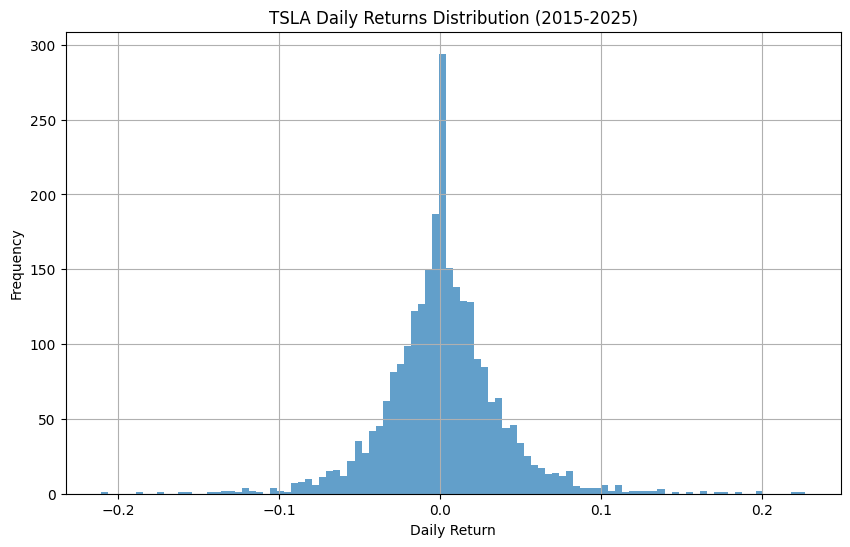

In [10]:
# Plot TSLA returns distribution
plt.figure(figsize=(10, 6))
final_data["TSLA"]["Daily Return"].hist(bins=100, alpha=0.7)
plt.title("TSLA Daily Returns Distribution (2015-2025)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()